# VGGNet (2014)
* Del grupo de Visual Geomery Group (grupo de geometria visual) de la Universidad de Oxford).
* Gano el concurso del ImageNet en 2014. Se publico el trabajo en el 2015, Simonyan y Zisserman. Referencia en las notas de clase.
* Usaron 14 millones de imagenes con 1000 etiquetas.

La arquitectura se muestra en la Figura



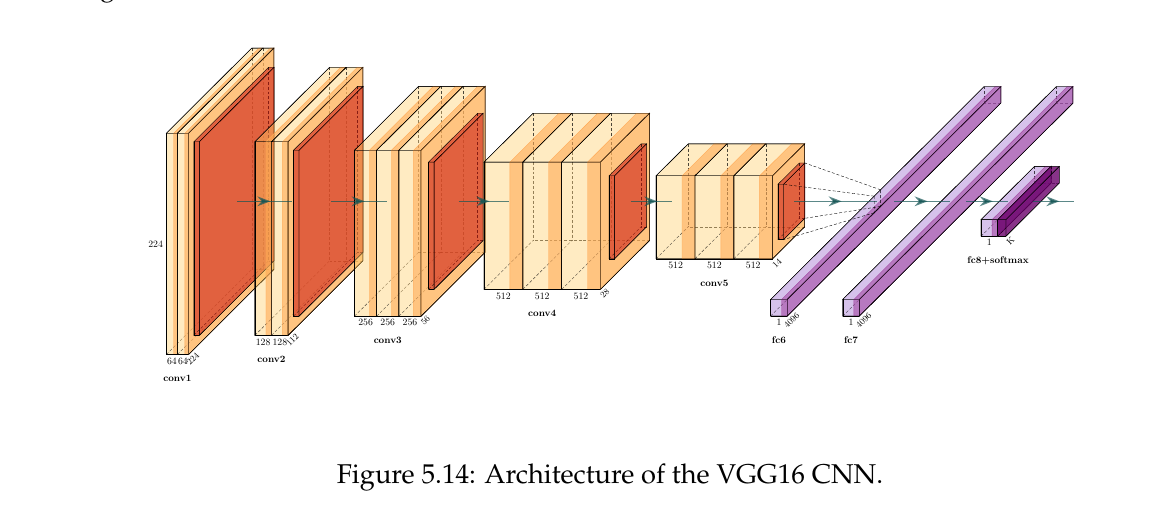

## Descripcion de la arquitectura.
No vamos a ser tan detallados como en las anteriores (LeNet, AlexNet).

* Capa de entrada y primera convolucion. La entrada tiene $224 \times 224 \times 3$. La convolucion se hace con 64 filtros.o

* Segunda convolucion: Se usan 128 filtros. Seguida de MaxPooling.

* Tercera convolucion (son 3 convoluciones) cada una con 256 filtros. MaxPooling.

* Cuarta convolucion (son 3 convoluciones) cada una con 512 filtros. MaxPoooling.

* Quinta convolucion (tres convoluciones) con 512 filtros. MaxPooling.

* Vectorizacion (flattening) a 4096 nodos
* Densa (todos con todos) a 4096
* Sofmax a 1000 clases.

El modelo tiene 134 millones de parametros. Lo que lo hace muy complejo.



In [ ]:
# load libraries
def vgg_block(layer_in, n_filters, n_conv):
    # add conv layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)

    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

El ejercicio que se programa en las notas de clase da una precision de mas 90% en entrenamiento pero un poco 50.74% en prueba. Esto es un sintoma de **overfitting**.




# GoogLeNet (2014): Familia Inception.

* Publicada originalmente en 2015 por Szegedy et al. (referencia en las notas de clase).

* Hay un cambio "brusco" de esta con relacion a las anteriores. No es secuencial (en paralelo).

* Esta formada por "inception blocks".

* Los autores estaban viendo una cantidad de capas convolutivas a traves de los anhos cada vez mas profundas y quisieron innovar.

* De Google. GoogLeNet (Google, Lecun, Net).

* La Figura siguiente muestra la topologia de la red.

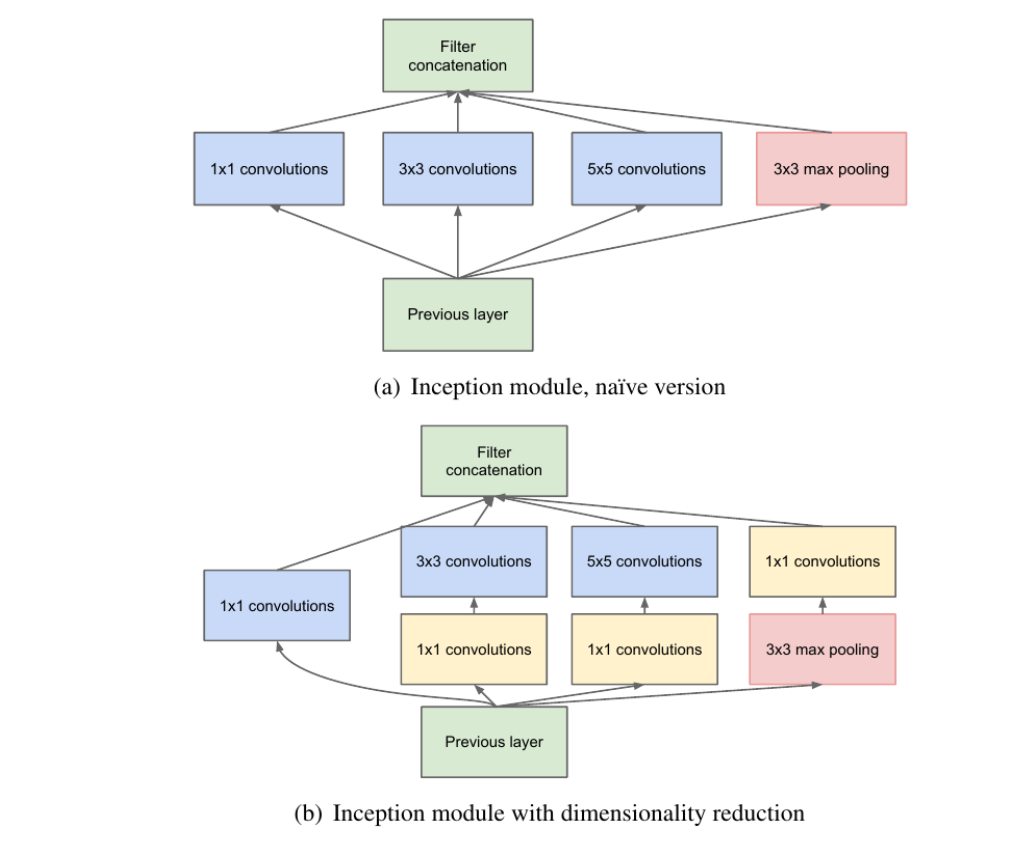

## Que es una     $1 \times 1$ convolucion? y para que sirve.

* Es poco comun y se uso por primera vez en 2013. Min Lin et al., Network In Network.

* Como el kernel es tan pequenho, reduce el numero de parametros.

* Colapsa la dimension de los filtros creando un producto punto en la direccion de los filtros. En este sentido es como un  AveragePooling pero a lor largo de la ultima dimension (canales).

Veamos esto analiticamente. El filtro tiene, por ahora, tres indices $f_{ij \ell}$.

$$\text{out}_{ij} = \sum_{\ell=1}^k f_{ij \ell} \text{in}_{i j \ell}  \quad , \quad i=1,2, \cdots, \text{width} \quad , \quad j = 1, 2, \cdots, \text{height}$$



En realidad puede haber una cantidad mayor que uno de salida de los filtros. Entonces estamos hablando de que los filtros realmente son un tensor de rango 4. $f_{ij \ell}^p$ij \ell}

$$out_{ij}^p = \sum_{\ell=1}^k f_{ij \ell}^p \text{in}_{i j \ell} $$



La razon por la cual la convolucion $1 \times 1$ reduce el numero de parametros es la formula que ya hemos visto varias veces.

$$\# \text{parametros} = (1 \times 1 \times \text{detpth}+1) \times nf $$

Fijense que comparado a una convolucion de $3 \times 3$ este numero es 9 veces mas pequenho, o a una de $5 \times 5$ este numero es 25 veces mas pequenho.

Veamos como la convolucion $1 \times 1$ sirve para rebajar parametros en la GoogLeNet.

Asumamos que la entrada es $224 \times 224 \times 3$.
Queremos usar kernel de $5 \times 5$, y el numero de  filtros es 256.

El numero de multiplicaciones es:

$$5 \times 224 \times 224 \times 3 \times   \times 256 = 963379200
 $$

Ahora bien observe la GoogLeNet forma "dimensionality reduction"

$$1 \times 1 \times 224 \times 224 \times 3 + 5 \times 5 \times 224 \times 224 \times 1 \times 256 = 321276928 $$
Es la tercera parte de la convolucion directa de $5 \times 5$.

GoogLeNet = Inception

Hay varios modelos del "Inception".
* La primera arquitectura del Inception v1 fue publicada en 2014.
* Tambien se publico alli la version 2 Inception v2.

* En 2016 se publicaron Inception v4 y la ResNet (???)

* La Xception (Extreme Inception). Esta fue publicada for Francois Chollet en 2016 (el fundador de Keras).

[Josepth P Cohen](https://josephpcohen.com/w/visualizing-cnn-architectures-side-by-side-with-mxnet/)  tiene unas ilustraciones buenas de las redes que hemos visto hasta el momento


Hacemos unas funciones de la GoogLeNet a continuacion.

In [ ]:
from os import access
# funcion para crear un modulo incepcion
def inception_module( layer_in, f1, f2, f3):

    # 1 x 1 convolution
    conv1 = Conv2D(f1 , (1,1), padding='same', activation='relu')(layer_in)


    # 3 x 3 convolution
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)

    # 5 x 5 convolution
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)

    #MaxPooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)

    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)


Veamos la implemtacion del modulo reduccion de dimensionalidad.

In [ ]:
# Function for creating a inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):

    # primer nivel 1x1
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

    # convolucion 1x1
    conv12 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)

    # convolucion 1x1
    conv13 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)

    # maxpooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)

    # segundo nivel
    # 3x3 conv
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv12)

    # 5x5 conv
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv13)

    # 1x1 conv
    conv11 = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)

    # concatenacion
    layer_out = concatenate([conv1, conv3, conv5, conv11], axis=-1)

    return layer_out

El sitio en
[GitHub](https://gist.github.com/joelouismarino/a2ede9ab3928f999575423b9887abd14) muestra una implementacion completa del Inception. (creo que es la v1).

[Jason Brownlee](https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/) es un referente para estos modelos de deep learning. Hay mucho materia que ofrece para entender mejor estas redes.


# ResNet (Residual Net).
 y
* Ganadora del concurso de ImageNet del 2015. Primer lugar.
* Microsoft. Los autores He et al., (referencia en las notas de clase).

## Explicacion del nombre **residual**.

Asuma que $\mathcal{H}(x)$ define la capa de salida. El residual o diferencia entre la entrada $x$ $\mathcal{H}$ estado por

$$\mathcal{F} = \mathcal{H} - x $$
De forma que podemos escribir la salida como, despejando

$$ \mathcal{H} = \mathcal{F} +  x $$

Veamos varias graficas que explican el corazon de la red.



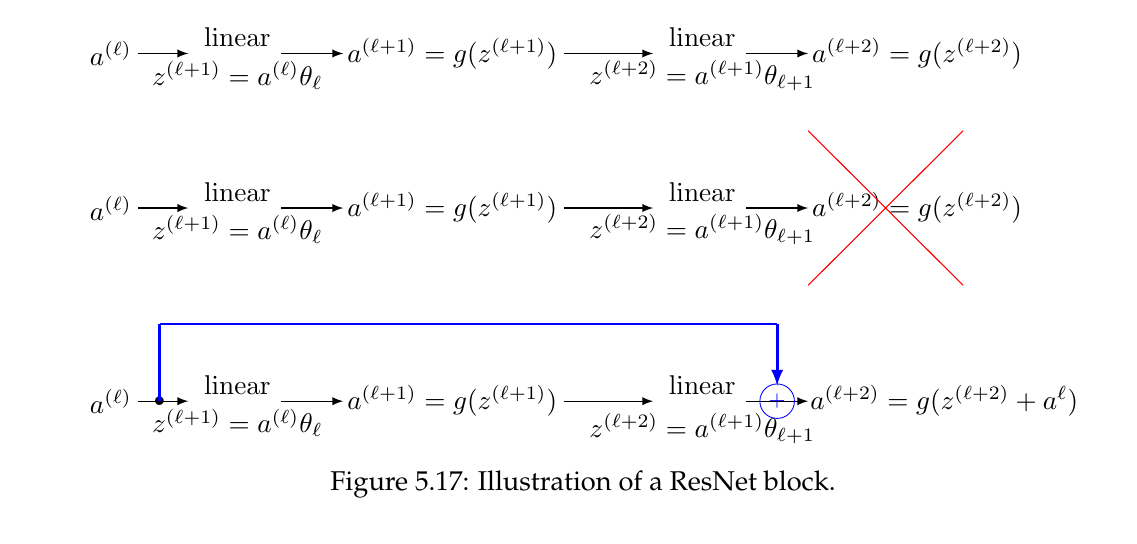

La linea azul de la Figura 5.17 se llama **shortcut connection** (corto circuito, desecho).

Veamos la implementacion del ResNet block en `Phython`



In [ ]:
from tensorflow.keras.layers import Conv2D, Add, Activation

def residual_module(x, n_filters):
    # first conv + ReLu
    conv1 = Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    conv1 = Activation('relu')(conv1)

    # segunda convolucion SIN activacion
    conv2 = Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal')(conv1)

    # agregamos la entrada original X
    layer_out = Add()([conv2, x])

    # ahora si aplicamos la activacion
    layer_out = Activation('relu')(layer_out)

    return layer_out

La Figura del ResNet, del articulo original

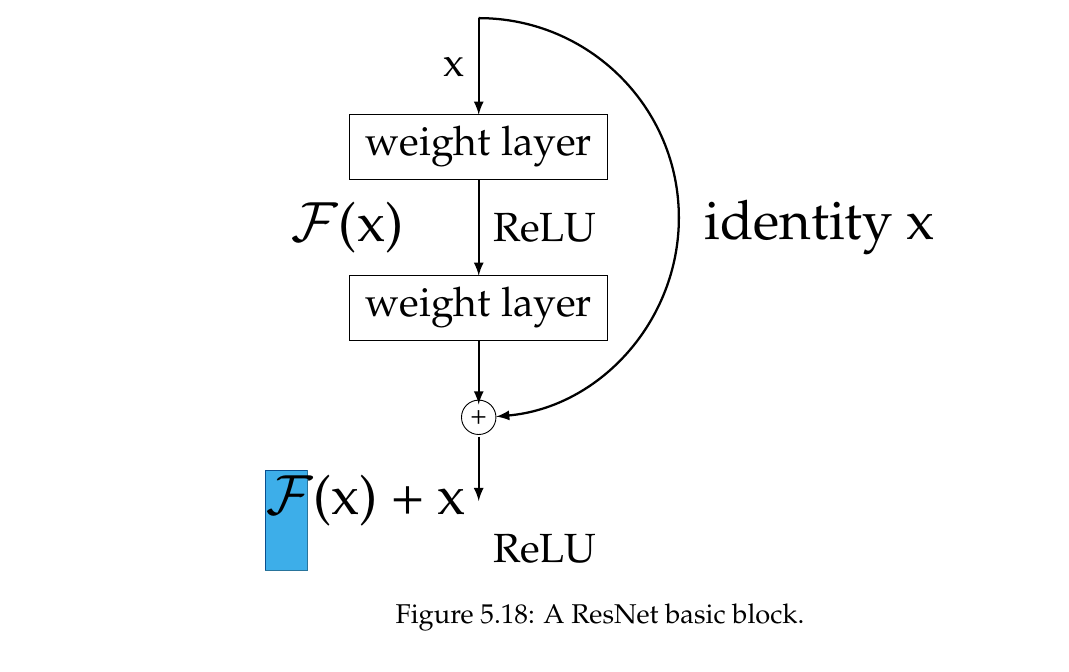

El enlace
[How to build a ResNet from scratch with tensorflow2 and keras](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-resnet-from-scratch-with-tensorflow-2-and-keras.md)
es util para ver la implementacion completa del ResNet en el CIFAR10.

**Por que podria ser importante la ResNet**?
El ResNet es demasiado profundo. Tiene muchas capas. Entonces es muy sensible al problema de vanishing/exploding gradient.

Si el gradiene de $\mathcal{F}$ es muy pequenho, entonces piense en lo siguiente

$$\nabla (\mathcal{F} + x) = \nabla \mathcal{F} + I $$
La identidad $I$ no sufre ni de vanishing ni de exploding gradient.

Por esta razon el ResNet se usa en la arquitectura de los Transformers que es la arquitectura de ChatGPT.

Hay un articulo llamado "Visualizing The Loss Landscape of Neural Nets" escrito por Xu et al. (referencia en las notas de clase). Este articulo trata de vender la idea de la importancia del ResNet (skip connection, shortcut connection). La Figura 5.19 muestra dos funciones de costo. Con y sin "skip connection"




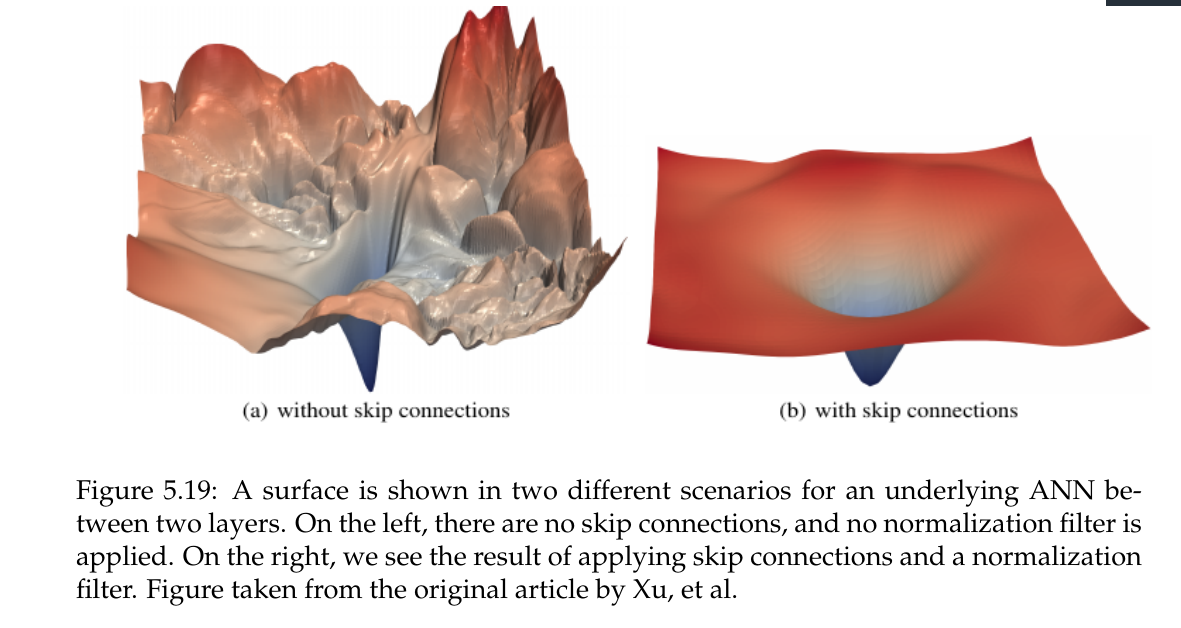

# Proxima clase:
* Recurrent Neural Networks (Redes Neuronales Recurrentes)
* Long sHort Term Memory (LSTM : muy utiles para NLP, lenguajes, adivinar la proxima palabra o frase.
* Gated Recurrent Units GRU

Mas adelante:
* DL semisupervisado
* DL no supervisado
* Transfer Learning

El ultimo capitulo NLP: Natural Language Processing.